# Deepmind TurnerLab (Pillar IV) Dataset 06-07-2023

**Data Source:** *16FlYMaze System, Turner Lab, HHMI Janelia Research Campus*

**Collected By:** *Kaitlyn Boone, Aparna Dev, PTR, HHMI Janelia Research Campus*

**Code Author:** *Rishika Mohanta*


In [1]:
# LIBRARY IMPORTS

# import libraries
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
import matplotlib.pyplot as plt         # for plotting
import scipy.optimize as opt            # for optimization
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar
import pickle                           # for saving and loading
import os                               # for file operations

# import cognitive models
from pygorl.cogpolicy import *     # Cognitive Policy Learning models
from pygorl.cogq import *          # Cognitive Q-learning models

In [4]:
data_path = '../data/dmData_06-07-2023/' # path to data files
fit_path = '../processed_data/dmData_06-07-2023/' # path to fitted models
quality_control = 'full' # whether to perform quality control (valid options: minimal, full, none)
last_date = '2023-06-10 00:00:00' # last date of data collection

In [5]:
# DATA LOADING

# load data
choice_data = np.loadtxt(data_path + 'choices.csv', delimiter=',')
reward_data = np.loadtxt(data_path + 'rewards.csv', delimiter=',')

# turn into integers
choice_data = choice_data.astype(int)
reward_data = reward_data.astype(int)

if choice_data.shape != reward_data.shape:
    raise ValueError('Sizes do not match.')

N = choice_data.shape[0]    # number of flies

print("Data loaded successfully with N = {} flies and {} maximum trials".format(N, choice_data.shape[1]))

# metadata
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata['Starvation Time'] = pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')

Data loaded successfully with N = 507 flies and 1010 maximum trials


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_59340/330535713.py:8: RuntimeWarning: invalid value encountered in cast
  choice_data = choice_data.astype(int)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_59340/330535713.py:9: RuntimeWarning: invalid value encountered in cast
  reward_data = reward_data.astype(int)


In [6]:
# QUALITY CONTROL

if quality_control == 'minimal':
    qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)
    choice_data = choice_data[qc]
    reward_data = reward_data[qc]
    metadata = metadata[qc]
if quality_control == 'full':
    qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)
    metadata = metadata[qc]
    metadata = metadata[metadata['Experiment Start Time'] < last_date].groupby('Fly Experiment').head(3)
    choice_data = choice_data[metadata.index]
    reward_data = reward_data[metadata.index]
    metadata.reset_index(drop=True, inplace=True)

print("{}/{} ({}) flies passed quality control".format(choice_data.shape[0], N, "{:0.2f}".format(choice_data.shape[0]/N*100)))

N = choice_data.shape[0]    # number of flies

209/507 (41.22) flies passed quality control


## Preliminary Data Analysis

### Dataset Properties

In [7]:
# Experiment Distribution and Odor Identity
experiments = metadata['Fly Experiment']

n_unique_experiments = experiments.apply(lambda x: x.replace('_reciprocal', '')).unique().shape[0]
replicates_per_experiment = np.unique(experiments, return_counts=True)[1]
variations_per_experiment = experiments.unique().shape[0] / experiments.apply(lambda x: x.replace('_reciprocal', '')).unique().shape[0]
print("Dataset has {} unique experiments with ~{:0.1f} reciprocal variations each. ".format(n_unique_experiments, variations_per_experiment),end='')
print("Every experiment has {:d} ± {:.1f} flies".format(int(np.mean(replicates_per_experiment)), int(np.std(replicates_per_experiment))))

if np.unique(metadata['Odor 1']).shape[0] == 1:
    odor1 = np.unique(metadata['Odor 1'])[0]
else:
    raise ValueError('More than one odor 1.')

if np.unique(metadata['Odor 2']).shape[0] == 1:
    odor2 = np.unique(metadata['Odor 2'])[0]
else:
    raise ValueError('More than one odor 2.')

print("Odor 1 (Conc. in Paraffin) = {}".format(odor1))
print("Odor 2 (Conc. in Paraffin) = {}".format(odor2))


Dataset has 37 unique experiments with ~2.0 reciprocal variations each. Every experiment has 2 ± 0.0 flies
Odor 1 (Conc. in Paraffin) = MHO 1:1000
Odor 2 (Conc. in Paraffin) = HAL 1:1000


Starvation period shifted by 24 hours multiples to get in range.


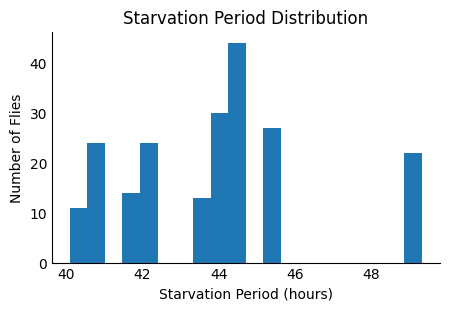

In [8]:
# Starvation Period Distribution

starvation_period = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')-pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')
# if starvation_period is less than 30 hours or more than 50 hours, print warning and shift by 24 hours multiples to get in range
if np.min(starvation_period.dt.total_seconds()/3600) < 30 or np.max(starvation_period.dt.total_seconds()/3600) > 50:
    print("WARNING: Starvation period is out of range for some flies.")
    def correct_time(x):
        if x < pd.to_timedelta(30, unit='h'):
            return x + pd.to_timedelta(24*(np.round(x.total_seconds()/3600/24)+2), unit='h')
        elif x > pd.to_timedelta(50, unit='h'):
            return x + pd.to_timedelta(-24*(np.round(x.total_seconds()/3600/24)-2), unit='h')
        else:
            return x
    starvation_period = starvation_period.apply(correct_time)
    print("Starvation period shifted by 24 hours multiples to get in range.")

# plot starvation period histogram
plt.figure(figsize=(5,3))
plt.hist(starvation_period.dt.total_seconds()/3600, bins=20)
plt.xlabel('Starvation Period (hours)')
plt.ylabel('Number of Flies')
plt.title('Starvation Period Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.show()

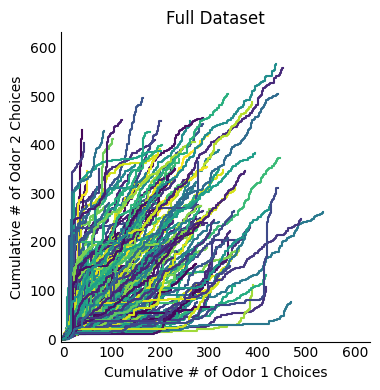

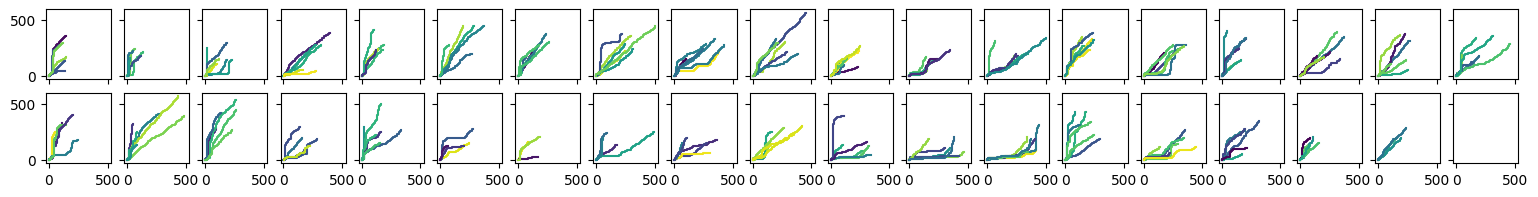

In [9]:
# Fly Behavior

# Full Dataset
fig,ax = plt.subplots(1,1,figsize=(4,4))
for i in range(N):
    ax.plot(np.cumsum(choice_data[i,:]==0), np.cumsum(choice_data[i,:]==1), color=plt.cm.viridis(np.random.rand()))
ax.set_xlabel('Cumulative # of Odor 1 Choices')
ax.set_ylabel('Cumulative # of Odor 2 Choices')
ax.set_xlim([-5,choice_data.shape[1]/1.6])
ax.set_ylim([-5,choice_data.shape[1]/1.6])
ax.set_aspect('equal')
ax.set_title('Full Dataset')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# Individual Experiments

# find most balanced factorization of n_unique_experiments
factors = np.array([i for i in range(1,n_unique_experiments+1) if n_unique_experiments%i==0])
if len(factors) == 2:
    factors = np.array([i for i in range(1,(n_unique_experiments+1)+1) if (n_unique_experiments+1)%i==0])

if factors.shape[0] % 2 == 0:
    size_x, size_y = factors[int(factors.shape[0]/2)], factors[int(factors.shape[0]/2)-1]
else:
    size_x, size_y = factors[int(factors.shape[0]/2)], factors[int(factors.shape[0]/2)+1]
fig,ax = plt.subplots(size_y,size_x,figsize=(size_x,size_y),sharex=True,sharey=True)
for i in range(n_unique_experiments):
    name,rec_name = 'exp{}.csv'.format(i+1),'exp{}_reciprocal.csv'.format(i+1)
    experiments = metadata['Fly Experiment'][metadata['Fly Experiment'] == name]
    reciprocal_experiments = metadata['Fly Experiment'][metadata['Fly Experiment'] == rec_name]
    for j in range(experiments.shape[0]):
        ax.flatten()[i].plot(np.cumsum(choice_data[experiments.index[j],:]==0), np.cumsum(choice_data[experiments.index[j],:]==1), color=plt.cm.viridis(np.random.rand()))
    for j in range(reciprocal_experiments.shape[0]):
        ax.flatten()[i].plot(np.cumsum(choice_data[reciprocal_experiments.index[j],:]==1), np.cumsum(choice_data[reciprocal_experiments.index[j],:]==0), color=plt.cm.viridis(np.random.rand()), linestyle='-')



In [12]:
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
# sort by experiment start time
metadata = metadata.sort_values(by='Experiment Start Time')
metadata.reset_index(drop=True)
metadata[metadata['Fly Experiment'] == 'exp40.csv']['Experiment Start Time']

479   2023-06-23 10:03:21
175   2023-06-23 10:03:21
209   2023-06-23 10:03:21
398   2023-06-23 13:28:30
Name: Experiment Start Time, dtype: datetime64[ns]

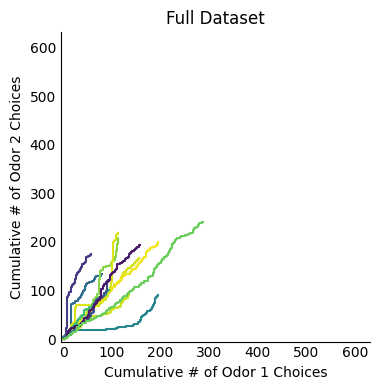

12


In [10]:
# Full Dataset
choice_data_temp = choice_data.copy()
# remove flies from experiments after 23th June 2023
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata_temp = metadata[metadata['Experiment Start Time'] > pd.to_datetime('2023-06-09 00:00:00', format='%Y-%m-%d %H:%M:%S')]
choice_data_temp = choice_data_temp[metadata_temp.index,:]

fig,ax = plt.subplots(1,1,figsize=(4,4))
for i in range(choice_data_temp.shape[0]):
    ax.plot(np.cumsum(choice_data_temp[i,:]==0), np.cumsum(choice_data_temp[i,:]==1), color=plt.cm.viridis(np.random.rand()))
ax.set_xlabel('Cumulative # of Odor 1 Choices')
ax.set_ylabel('Cumulative # of Odor 2 Choices')
ax.set_xlim([-5,choice_data_temp.shape[1]/1.6])
ax.set_ylim([-5,choice_data_temp.shape[1]/1.6])
ax.set_aspect('equal')
ax.set_title('Full Dataset')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print(choice_data_temp.shape[0])